In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
import matplotlib
import pandas
import numpy
print (matplotlib.__version__)
print (pandas.__version__)
print (numpy.__version__)

1.5.3
0.19.2
1.11.2


In [3]:
#Reading ratings file:
df = pd.read_csv('/home/nadine/Pictures/Memoir/data/data.csv')

In [4]:
n_users = df.UserId.unique().shape[0]
n_jobs = df.JobId.unique().shape[0]
print (' Total Number of users = ' + str(n_users) + ' | Total Number of jobs = ' + str(n_jobs) )
n_users

 Total Number of users = 2500 | Total Number of jobs = 150


2500

In [5]:
from sklearn import cross_validation as cv
train_data, test_data = cv.train_test_split(df,test_size=0.25, random_state=0)

train_data = pd.DataFrame(train_data)
test_data = pd.DataFrame(test_data)

# Create training and test matrix
R = np.zeros((n_users, n_jobs))
for line in train_data.itertuples():
    R[line[1]-1, line[2]-1] = line[3]  

T = np.zeros((n_users, n_jobs))
for line in test_data.itertuples():
    T[line[1]-1, line[2]-1] = line[3]


/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [6]:
# Index matrix for training data
I = R.copy()
I[I > 0] = 1
I[I == 0] = 0

# Index matrix for test data
I2 = T.copy()
I2[I2 > 0] = 1
I2[I2 == 0] = 0

In [7]:
# Predict the unknown ratings through the dot product of the latent features for users and items 

def prediction(P,Q):
    return np.dot(P.T,Q)


In [8]:
lmbda = 0.2 # Regularisation weight
k = 20  # Dimensionality of the latent feature space
m, n = R.shape  # Number of users and items
n_epochs = 17  # Number of epochs
gamma=0.01  # Learning rate

P = 3 * np.random.rand(k,m) # Latent user feature matrix
Q = 3 * np.random.rand(k,n) # Latent movie feature matrix

In [9]:
# Calculate the RMSE
def rmse(I,R,Q,P):
    return np.sqrt(np.sum((I * (R - prediction(P,Q)))**2)/len(R[R > 0]))

In [10]:
train_errors = []
test_errors = []

#Only consider non-zero matrix 
users,items = R.nonzero()      
for epoch in xrange(n_epochs):
    for u, i in zip(users,items):
        e = R[u, i] - prediction(P[:,u],Q[:,i])  # Calculate error for gradient
        P[:,u] += gamma * ( e * Q[:,i] - lmbda * P[:,u]) # Update latent user feature matrix
        Q[:,i] += gamma * ( e * P[:,u] - lmbda * Q[:,i])  # Update latent movie feature matrix
    train_rmse = rmse(I,R,Q,P) # Calculate root mean squared error from train dataset
    test_rmse = rmse(I2,T,Q,P) # Calculate root mean squared error from test dataset
    train_errors.append(train_rmse)
    test_errors.append(test_rmse)
    print "[Epoch %d/%d] train error: %f, test error: %f" \
    %(epoch+1, n_epochs, train_rmse, test_rmse)
    
print "Algorithm converged"

[Epoch 1/17] train error: 1.676299, test error: 1.694177
[Epoch 2/17] train error: 1.582065, test error: 1.603788
[Epoch 3/17] train error: 1.507143, test error: 1.532363
[Epoch 4/17] train error: 1.446727, test error: 1.475431
[Epoch 5/17] train error: 1.398967, test error: 1.431045
[Epoch 6/17] train error: 1.362416, test error: 1.397584
[Epoch 7/17] train error: 1.335256, test error: 1.373024
[Epoch 8/17] train error: 1.315468, test error: 1.355192
[Epoch 9/17] train error: 1.301120, test error: 1.342201
[Epoch 10/17] train error: 1.290347, test error: 1.332363
[Epoch 11/17] train error: 1.281330, test error: 1.324039
[Epoch 12/17] train error: 1.272824, test error: 1.316082
[Epoch 13/17] train error: 1.264715, test error: 1.308355
[Epoch 14/17] train error: 1.257620, test error: 1.301427
[Epoch 15/17] train error: 1.252018, test error: 1.295791
[Epoch 16/17] train error: 1.247926, test error: 1.291530
[Epoch 17/17] train error: 1.245103, test error: 1.288473
Algorithm converged


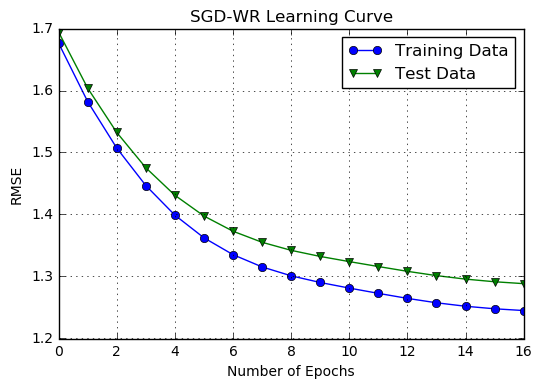

In [11]:
# Check performance by plotting train and test errors
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(n_epochs), train_errors, marker='o', label='Training Data');
plt.plot(range(n_epochs), test_errors, marker='v', label='Test Data');
plt.title('SGD-WR Learning Curve')
plt.xlabel('Number of Epochs');
plt.ylabel('RMSE');
plt.legend()
plt.grid()
plt.show()

In [12]:
# Calculate prediction matrix R_hat (low-rank approximation for R)
R = pd.DataFrame(R)
R_hat=pd.DataFrame(prediction(P,Q))

In [13]:
# Compare true ratings of user 27 with predictions
ratings = pd.DataFrame(data=R.loc[26,R.loc[26,:] > 0]).head(n=5)
ratings['Prediction'] = R_hat.loc[26,R.loc[26,:] > 0]
ratings.columns = ['Actual Rating', 'Predicted Rating']
ratings

,Actual Rating,Predicted Rating
1,3.0,3.245070
10,4.0,3.126391
13,3.0,2.941174
15,5.0,3.338837
17,3.0,3.283423


In [14]:
predictions = R_hat.loc[26,R.loc[26,:] == 0] # Predictions for jobs that the user 7 hasn't rated yet
top5 = predictions.sort_values(ascending=False).head(n=5)
recommendations = pd.DataFrame(data=top5)
recommendations.columns = ['Predicted Rating']

recommendations

,Predicted Rating
120,3.666286
115,3.558387
49,3.547550
6,3.540906
122,3.497249
